In [1]:
import numpy as np
import pandas as pd
import os
import random
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras_tuner import Hyperband
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
DATA_PATH = './data/images'
CNN_IMAGE_RESULTS = './results/cnn/images'
CNN_HISTORY_RESULTS = './results/cnn/history'
CNN_REPORT_RESULTS = './results/cnn/reports'
CNN_MODEL_RESULTS = './results/cnn/models'

TRAIN_DIRECTORY = 'train'
VALIDATION_DIRECTORY = 'val'
TEST_DIRECTORY = 'test'

SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
CATEGORY_DIRECTORIES = ['Chickenpox', 'Cowpox', 'Healthy', 'HFMD', 'Measles', 'Monkeypox']

In [3]:
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        total = 0
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"============ {dataset_type} dataset ===========")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg','jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
            total += len(images)
        print(f"Total image count: {total}")
        print("")

In [4]:
count_images(DATA_PATH)

============ train dataset ===========
Number of images in Cowpox: 800
Number of images in Healthy: 800
Number of images in HFMD: 800
Number of images in Measles: 748
Number of images in Chickenpox: 800
Number of images in Monkeypox: 800
Total image count: 4748

============ test dataset ===========
Number of images in Cowpox: 100
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 94
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 594

============ val dataset ===========
Number of images in Cowpox: 100
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 93
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 593



In [5]:
def load_images_to_df(base_path, dataset_type):
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([file_paths, labels], axis=1)

    samples = []
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label']==record])
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    return image_df

In [6]:
df_train = load_images_to_df(DATA_PATH, TRAIN_DIRECTORY)
df_train.head(10)

Path       Label
0  data/images/train/Healthy/HEALTHY_69_01_0_3962...     Healthy
1  data/images/train/Chickenpox/CHP_16_01_0_3194.jpg  Chickenpox
2      data/images/train/Cowpox/CWP_15_01_0_5158.jpg      Cowpox
3     data/images/train/Measles/MSL_16_01_0_3338.jpg     Measles
4   data/images/train/Monkeypox/MKP_65_01_0_2905.jpg   Monkeypox
5  data/images/train/Monkeypox/MKP_108_01_0_6757.jpg   Monkeypox
6  data/images/train/Healthy/HEALTHY_30_01_0_7765...     Healthy
7        data/images/train/HFMD/HFMD_03_01_0_114.jpg        HFMD
8  data/images/train/Healthy/HEALTHY_04_01_0_4417...     Healthy
9  data/images/train/Chickenpox/CHP_14_01_0_1461.jpg  Chickenpox

In [7]:
df_val = load_images_to_df(DATA_PATH, VALIDATION_DIRECTORY)
df_val.head(10)

Path       Label
0        data/images/val/Cowpox/CWP_14_01_0_4369.jpg      Cowpox
1         data/images/val/Cowpox/CWP_29_01_0_726.jpg      Cowpox
2         data/images/val/HFMD/HFMD_66_02_0_1643.jpg        HFMD
3    data/images/val/Chickenpox/CHP_02_01_0_1320.jpg  Chickenpox
4   data/images/val/Healthy/HEALTHY_52_01_0_6779.jpg     Healthy
5       data/images/val/Measles/MSL_08_01_0_8564.jpg     Measles
6       data/images/val/Measles/MSL_23_01_0_2983.jpg     Measles
7     data/images/val/Monkeypox/MKP_78_01_0_7004.jpg   Monkeypox
8   data/images/val/Healthy/HEALTHY_32_02_0_4352.jpg     Healthy
9  data/images/val/Healthy/HEALTHY_11_01_ORIGINAL...     Healthy

In [8]:
df_test = load_images_to_df(DATA_PATH, TEST_DIRECTORY)
df_test.head(10)

Path       Label
0       data/images/test/Cowpox/CWP_30_01_0_2732.jpg      Cowpox
1       data/images/test/HFMD/HFMD_119_01_0_9236.jpg        HFMD
2  data/images/test/Healthy/HEALTHY_20_01_0_1790.jpg     Healthy
3         data/images/test/HFMD/HFMD_65_01_0_381.jpg        HFMD
4      data/images/test/Measles/MSL_31_01_0_4215.jpg     Measles
5        data/images/test/HFMD/HFMD_64_01_0_1715.jpg        HFMD
6   data/images/test/Chickenpox/CHP_30_01_0_3593.jpg  Chickenpox
7    data/images/test/Monkeypox/MKP_24_02_0_6264.jpg   Monkeypox
8       data/images/test/Cowpox/CWP_05_02_0_5037.jpg      Cowpox
9  data/images/test/Healthy/HEALTHY_65_01_0_7956.jpg     Healthy

In [9]:
def pie_plot_from_df(df, title):
    pie = df["Label"].value_counts()
    pie.plot(kind="pie", autopct="%1.2f%%")
    plt.ylabel("")
    plt.xlabel(title)
    plt.show()

In [10]:
def show_images_from_df(df, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8), subplot_kw={"xticks":[], "yticks":[]})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Path[i], -1))
        ax.set_title(df.Label[i])
    plt.tight_layout()
    plt.show()

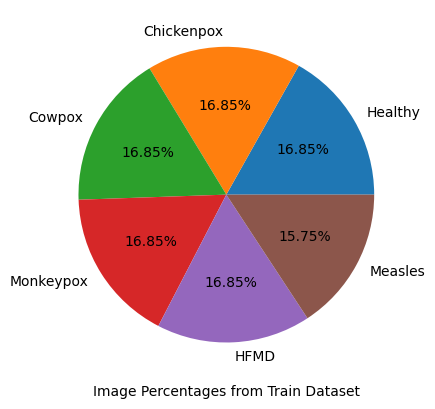

In [11]:
pie_plot_from_df(df_train, "Image Percentages from Train Dataset")

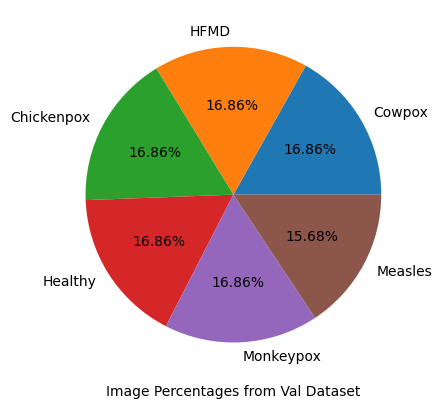

In [12]:
pie_plot_from_df(df_val, "Image Percentages from Val Dataset")

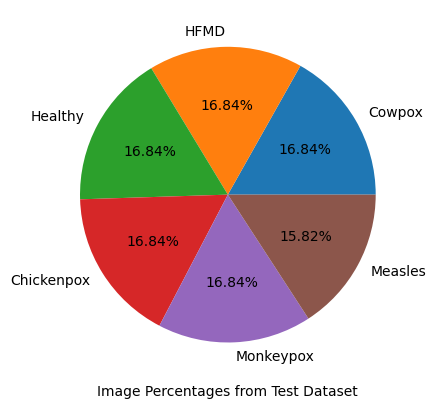

In [13]:
pie_plot_from_df(df_test, "Image Percentages from Test Dataset")

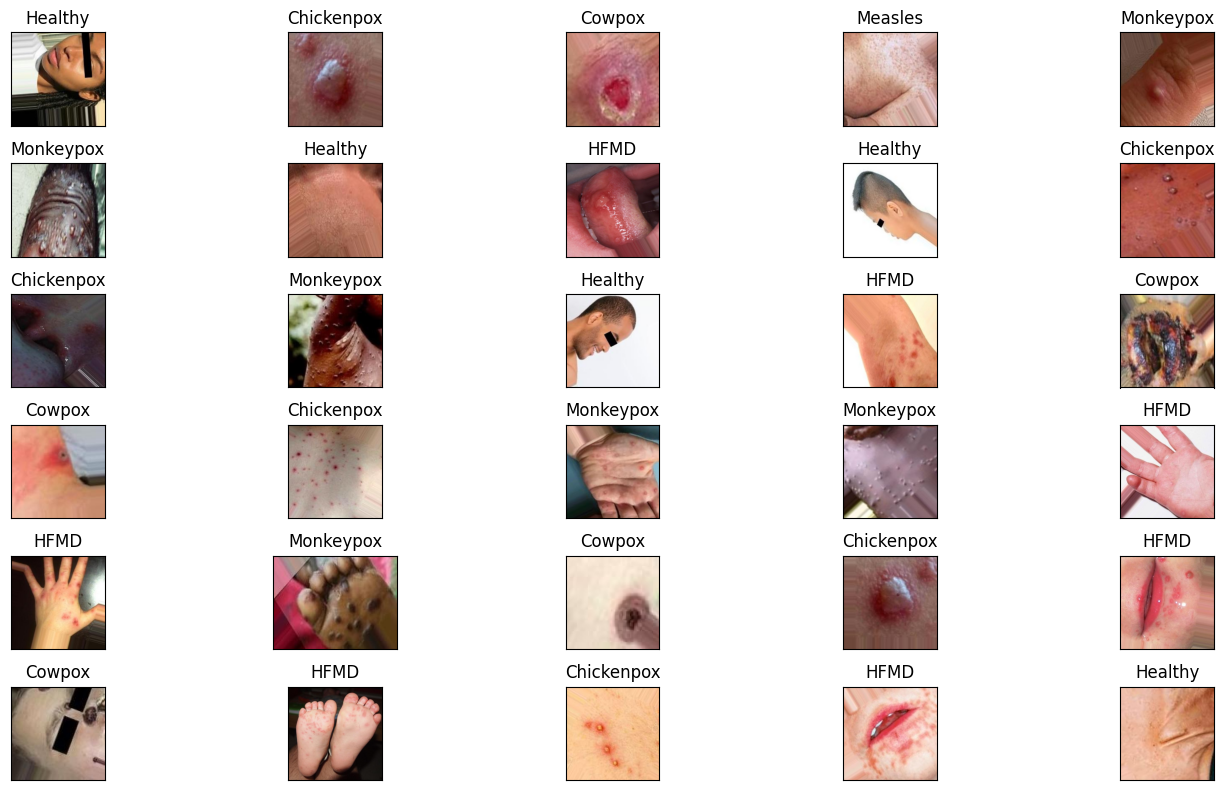

In [14]:
show_images_from_df(df_train, 6, 5)

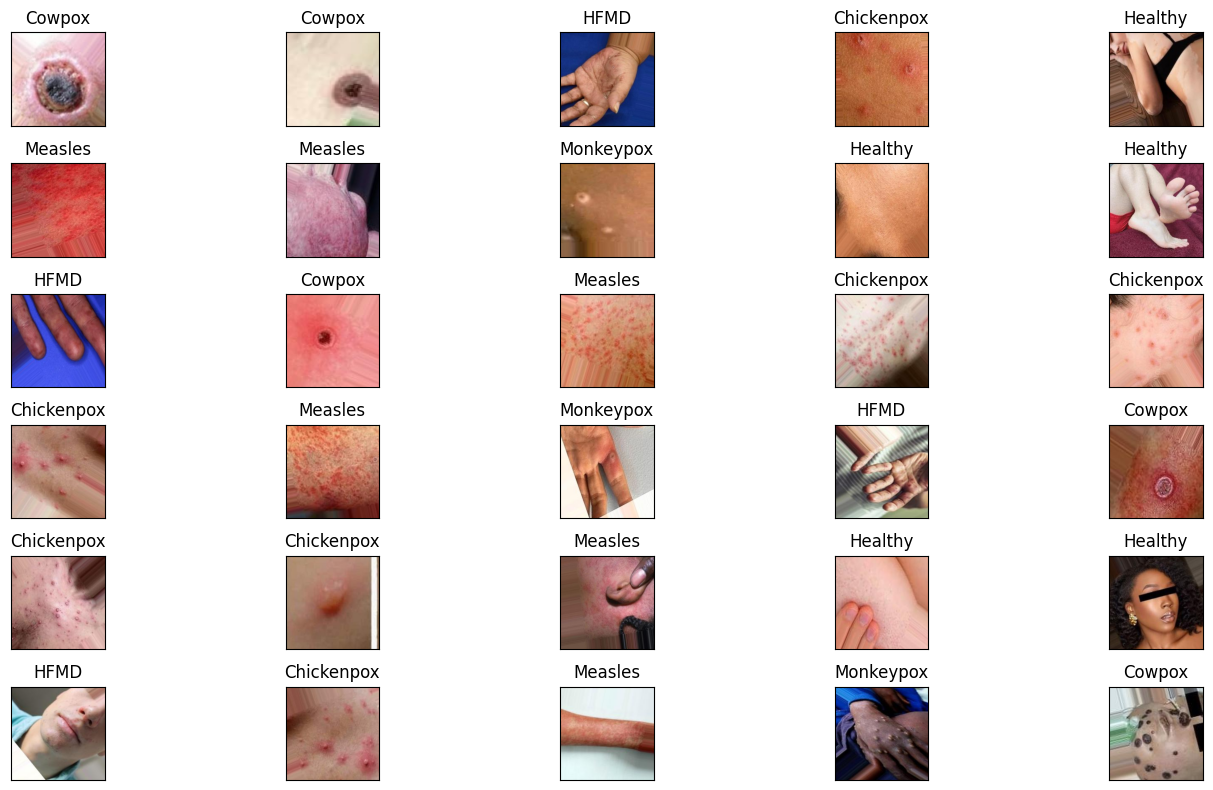

In [15]:
show_images_from_df(df_val, 6, 5)

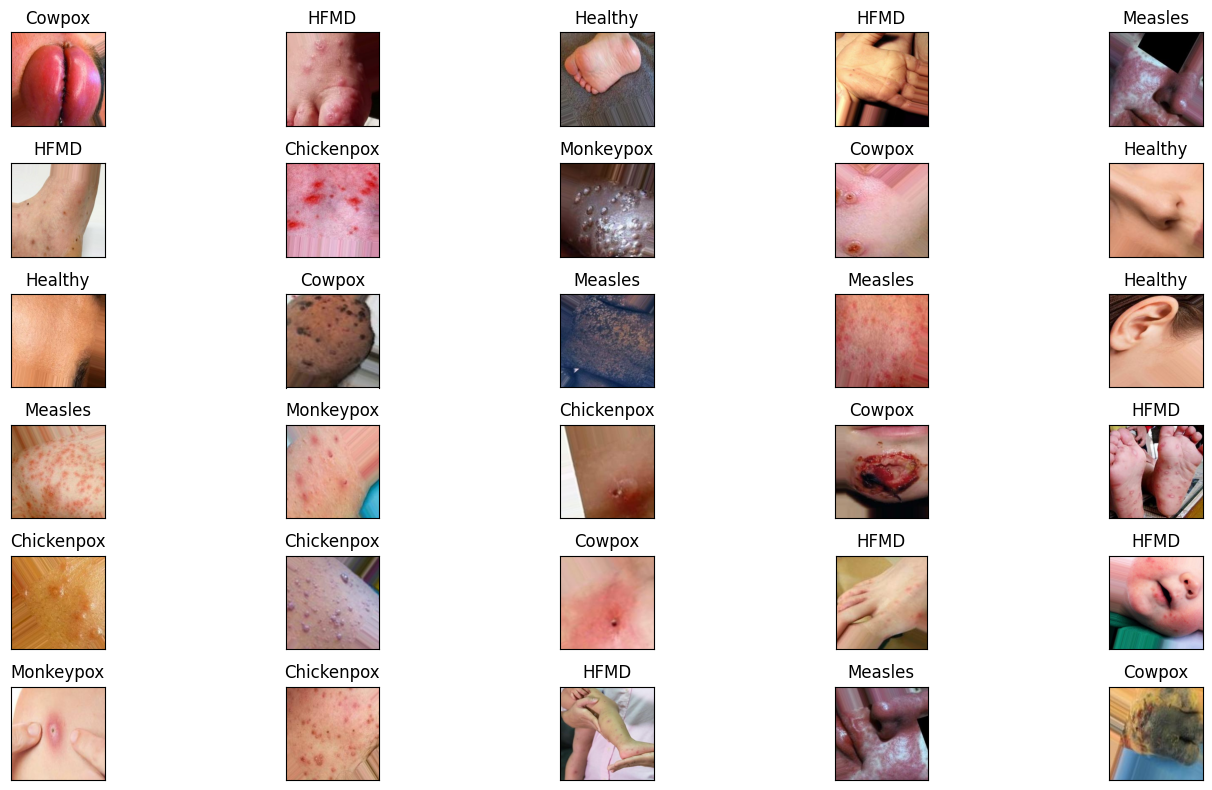

In [16]:
show_images_from_df(df_test, 6, 5)

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    fill_mode="nearest",
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

In [18]:
def create_dataset(generator, df, subset):
    images = generator.flow_from_dataframe(
        dataframe=df,
        x_col='Path', 
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42)
    print(f"{subset} class indices: {images.class_indices}\n")
    return images

In [19]:
train_dataset = create_dataset(train_generator, df_train, TRAIN_DIRECTORY)
val_dataset = create_dataset(val_generator, df_val, VALIDATION_DIRECTORY)
test_dataset = create_dataset(test_generator, df_test, TEST_DIRECTORY)

Found 4748 validated image filenames belonging to 6 classes.
train class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}

Found 593 validated image filenames belonging to 6 classes.
val class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}

Found 594 validated image filenames belonging to 6 classes.
test class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}



## Model Based on Random Values

2025-03-12 21:10:39.248813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-03-12 21:10:39.248840: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-12 21:10:39.248843: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-12 21:10:39.248904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-12 21:10:39.248945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


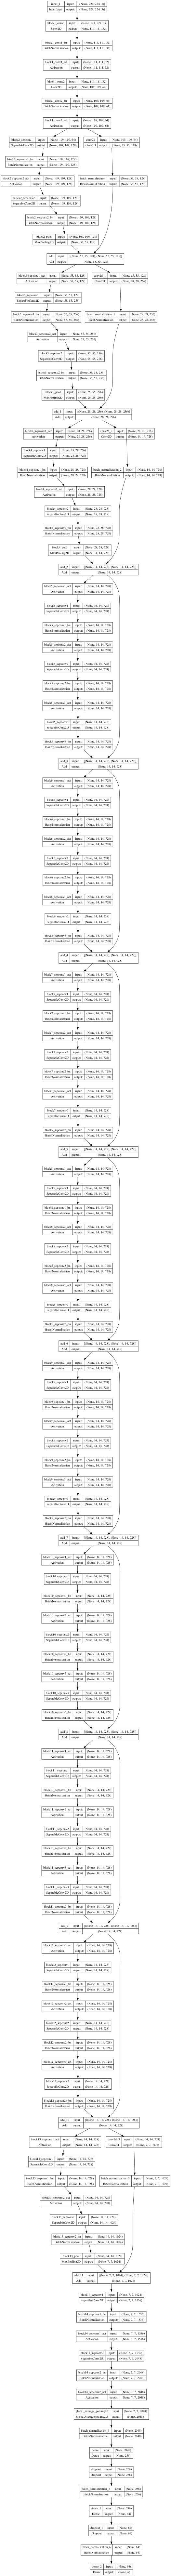

In [20]:
base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

inputs = base_model.input

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
outputs = Dense(len(CATEGORY_DIRECTORIES), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/xception_model_summary.png", show_shapes=True, dpi=50)

In [21]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min",
    restore_best_weights=True,
    verbose=1
)

In [22]:
history = model.fit(
    train_dataset,
    epochs=110,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/110


2025-03-12 21:10:42.929662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - ETA: 0s - loss: 0.8933 - categorical_accuracy: 0.6807

2025-03-12 21:11:20.125321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 47s 284ms/step - loss: 0.8933 - categorical_accuracy: 0.6807 - val_loss: 0.6978 - val_categorical_accuracy: 0.7656
Epoch 2/110
149/149 [==============================] - 50s 313ms/step - loss: 0.6414 - categorical_accuracy: 0.7704 - val_loss: 0.5682 - val_categorical_accuracy: 0.7926
Epoch 3/110
149/149 [==============================] - 43s 289ms/step - loss: 0.5898 - categorical_accuracy: 0.7881 - val_loss: 0.4887 - val_categorical_accuracy: 0.8162
Epoch 4/110
149/149 [==============================] - 40s 269ms/step - loss: 0.5439 - categorical_accuracy: 0.7999 - val_loss: 0.4737 - val_categorical_accuracy: 0.8347
Epoch 5/110
149/149 [==============================] - 43s 285ms/step - loss: 0.5234 - categorical_accuracy: 0.8115 - val_loss: 0.4573 - val_categorical_accuracy: 0.8297
Epoch 6/110
149/149 [==============================] - 38s 254ms/step - loss: 0.4885 - categorical_accuracy: 0.8237 - val_loss: 0.4314 - val_categorical_accuracy:

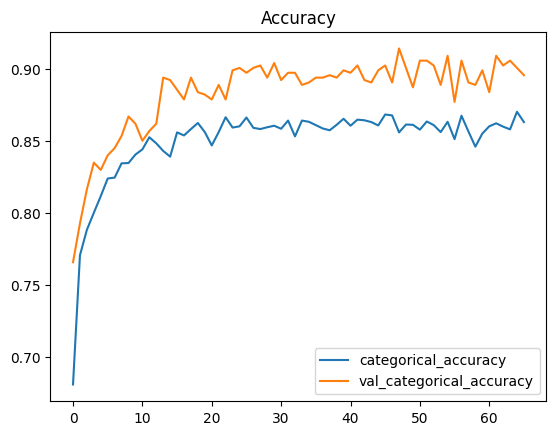

<Figure size 640x480 with 0 Axes>

In [23]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/xception_accuracy_plot.png")

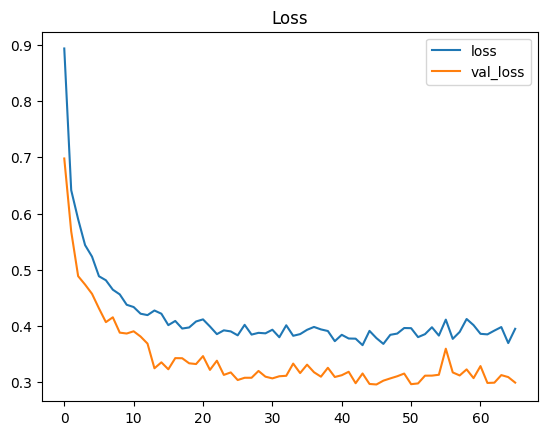

<Figure size 640x480 with 0 Axes>

In [24]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/xception_loss_plot.png")

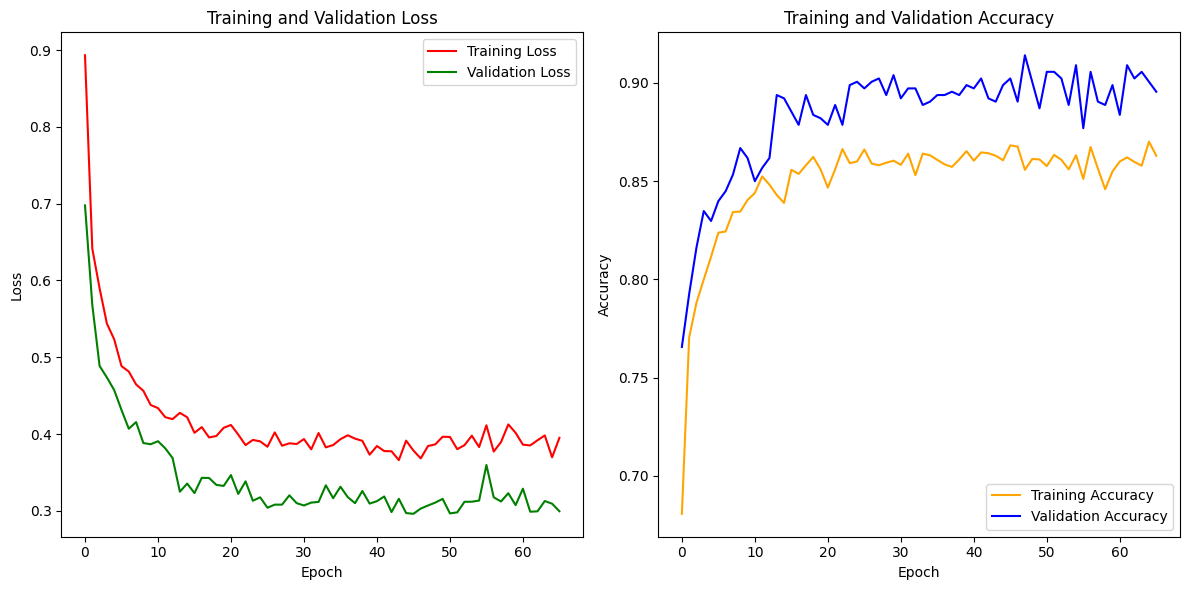

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/xception_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/xception_history.csv"
history_df.to_csv(history_csv)

In [26]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.30189
Test Accuracy: 89.73%


In [27]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

2025-03-12 21:55:16.118826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 4s 174ms/step


In [28]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/xception_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.18      0.18      0.18       100
      Cowpox       0.12      0.12      0.12       100
        HFMD       0.17      0.17      0.17       100
     Healthy       0.19      0.19      0.19       100
     Measles       0.20      0.22      0.21        94
   Monkeypox       0.19      0.18      0.18       100

    accuracy                           0.18       594
   macro avg       0.18      0.18      0.18       594
weighted avg       0.18      0.18      0.18       594



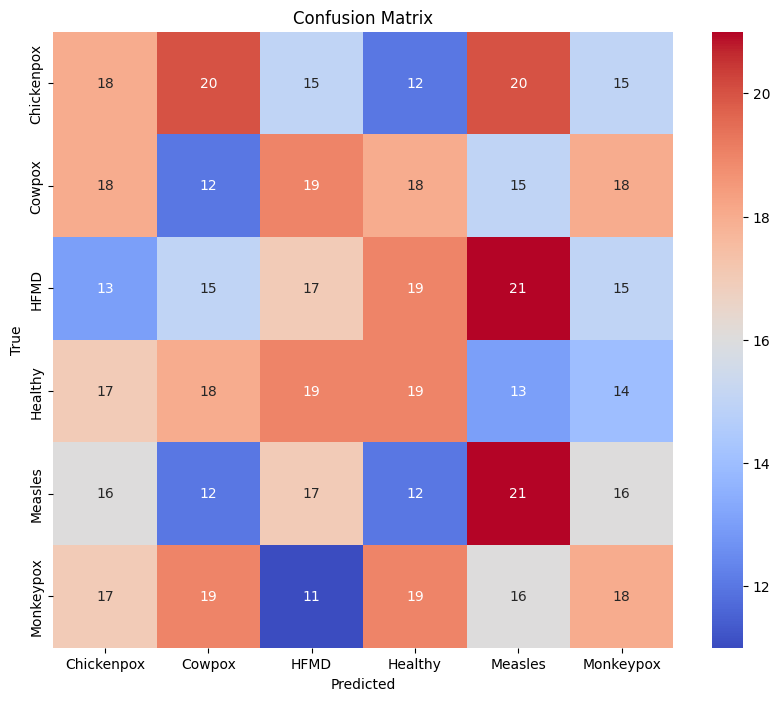

In [29]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/xception_confusion_matrix.png'
plt.savefig(heatmap_file)

In [30]:
model.save(f"{CNN_MODEL_RESULTS}/xception.h5")

2025-03-12 21:55:20.853236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 17ms/step


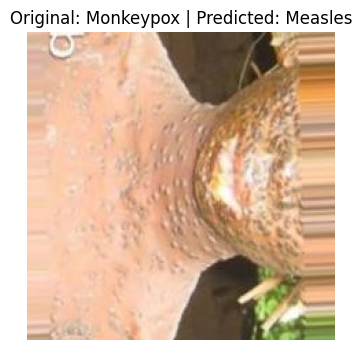

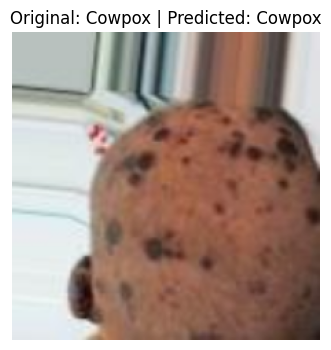

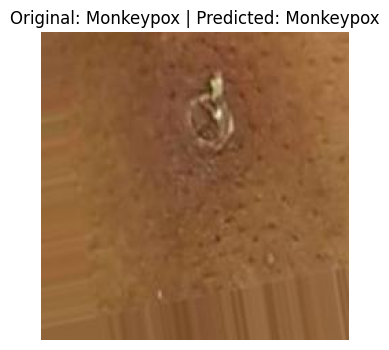

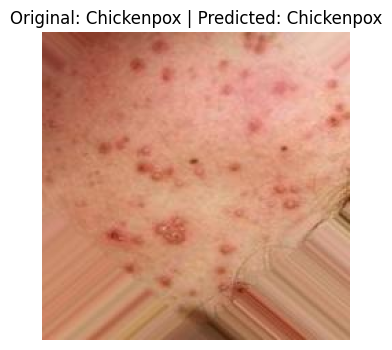

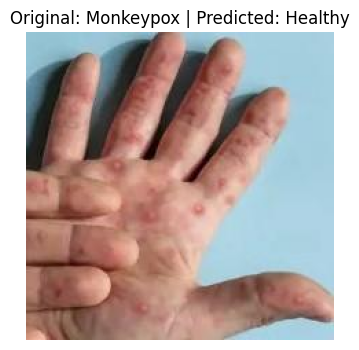

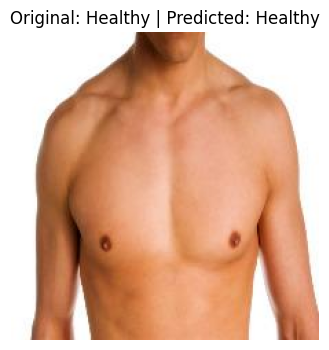

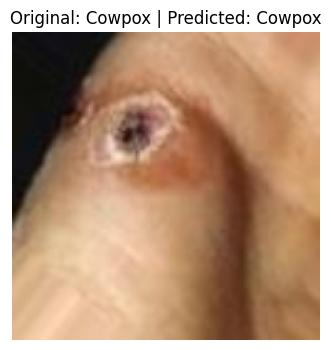

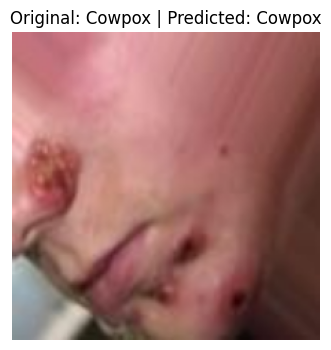

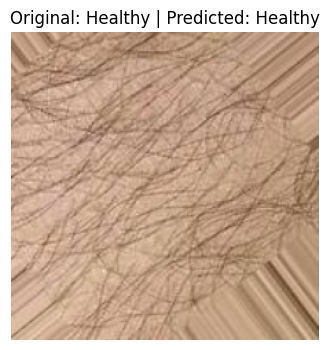

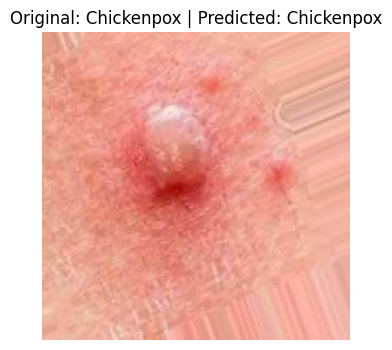

In [31]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.xception.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices.items()}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {label} | Predicted: {predicted_class}")

## Hyper-parameter Tuned Model

In [32]:
def build_model_with_hp(hp, base_model, num_classes):
    inputs = base_model.input

    x = base_model.output

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(units=hp.Int("dense_1_units", min_value=128, max_value=512, step=32), activation="relu")(x)
    x = Dropout(rate=hp.Choice("dropout_rate_1", values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]))(x)

    x = BatchNormalization()(x)
    x = Dense(units=hp.Int('dense_2_units', min_value=32, max_value=512, step=16), activation='relu')(x)

    x = Dropout(rate=hp.Choice('dropout_rate_2', values=[0.2,0.3,0.4,0.5,0.6,0.7]))(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

In [33]:
def perform_hyperparameter_tuning(model_name, base_model_func, train_dataset, val_dataset, num_classes, max_epochs=110, max_trials=5):
    base_model = base_model_func(weights="imagenet", include_top=False, input_shape=(224,224,3))

    # tuner = Hyperband(
    #     lambda hp: build_model_with_hp(hp, base_model, num_classes),
    #     objective="categorical_accuracy",
    #     max_epochs=max_epochs,
    #     factor=3,
    #     directory="hyperparameter_tuning",
    #     project_name=model_name
    # )

    tuner = RandomSearch(
        lambda hp: build_model_with_hp(hp, base_model, num_classes),
        objective="val_categorical_accuracy",
        max_trials=max_trials,  # Restrict to 5 trials
        executions_per_trial=1,
        directory="hyperparameter_tuning",
        project_name=model_name
    )

    tuner.search(train_dataset, validation_data=val_dataset, epochs=max_epochs, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    Best hyperparameters:
    - Units in Dense Layer 1: {best_hps.get('dense_1_units')}
    - Dropout Rate for Layer 1: {best_hps.get('dropout_rate_1')}
    - Units in Dense Layer 2: {best_hps.get('dense_1_units')}
    - Dropout Rate for Layer 2: {best_hps.get('dropout_rate_2')}
    - Learning Rate: {best_hps.get('learning_rate')}
    """)
    
    return tuner

In [34]:
tuner = perform_hyperparameter_tuning("Xception", Xception, train_dataset, val_dataset, len(CATEGORY_DIRECTORIES))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = build_model_with_hp(best_hps, base_model, len(CATEGORY_DIRECTORIES))
tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/xception_hp_model_summary.png", show_shapes=True, dpi=50)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    epochs=110,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)],
    class_weight=class_weights
)

Reloading Tuner from hyperparameter_tuning/Xception/tuner0.json

    Best hyperparameters:
    - Units in Dense Layer 1: 320
    - Dropout Rate for Layer 1: 0.4
    - Units in Dense Layer 2: 320
    - Dropout Rate for Layer 2: 0.2
    - Learning Rate: 0.001
    
Epoch 1/110


2025-03-12 21:55:27.234826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - ETA: 0s - loss: 0.9421 - categorical_accuracy: 0.6607

2025-03-12 21:56:05.937596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 43s 279ms/step - loss: 0.9421 - categorical_accuracy: 0.6607 - val_loss: 0.7242 - val_categorical_accuracy: 0.7454
Epoch 2/110
149/149 [==============================] - 39s 261ms/step - loss: 0.6751 - categorical_accuracy: 0.7534 - val_loss: 0.5838 - val_categorical_accuracy: 0.7976
Epoch 3/110
149/149 [==============================] - 38s 254ms/step - loss: 0.6178 - categorical_accuracy: 0.7843 - val_loss: 0.5064 - val_categorical_accuracy: 0.8179
Epoch 4/110
149/149 [==============================] - 38s 257ms/step - loss: 0.5713 - categorical_accuracy: 0.7904 - val_loss: 0.4680 - val_categorical_accuracy: 0.8246
Epoch 5/110
149/149 [==============================] - 39s 259ms/step - loss: 0.5153 - categorical_accuracy: 0.8142 - val_loss: 0.4447 - val_categorical_accuracy: 0.8398
Epoch 6/110
149/149 [==============================] - 39s 260ms/step - loss: 0.4891 - categorical_accuracy: 0.8241 - val_loss: 0.4569 - val_categorical_accuracy:

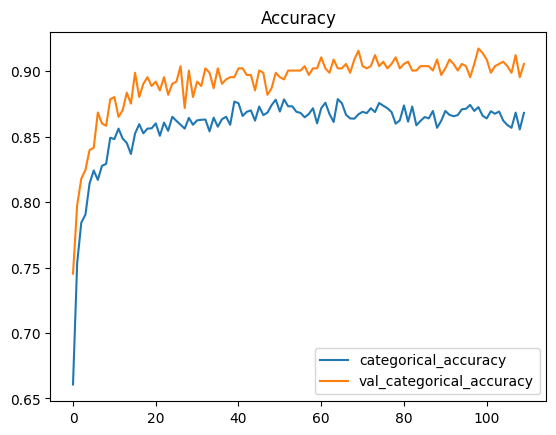

<Figure size 640x480 with 0 Axes>

In [35]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/xception_hp_accuracy_plot.png")

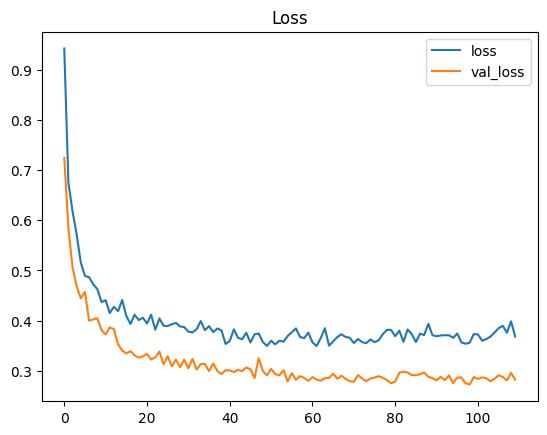

<Figure size 640x480 with 0 Axes>

In [36]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/xception_hp_loss_plot.png")

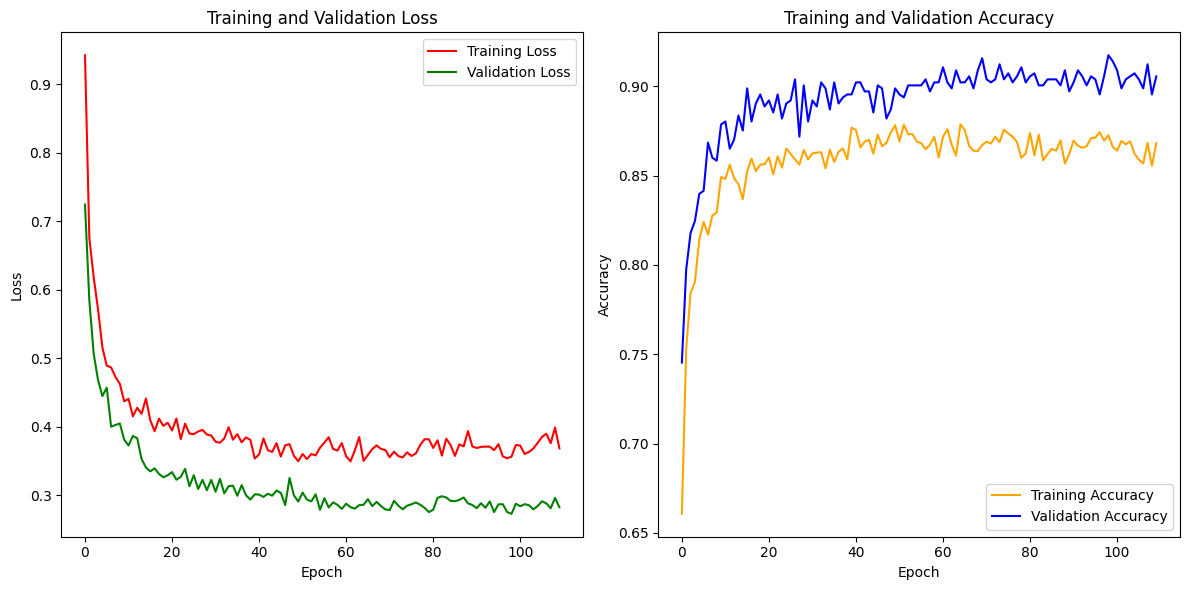

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/xception_hp_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/xception_hp_history.csv"
history_df.to_csv(history_csv)

In [38]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.26672
Test Accuracy: 90.07%


In [39]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

2025-03-12 23:08:09.081572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 4s 170ms/step


In [40]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/xception_hp_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.13      0.14      0.14       100
      Cowpox       0.08      0.08      0.08       100
        HFMD       0.14      0.14      0.14       100
     Healthy       0.18      0.19      0.19       100
     Measles       0.15      0.16      0.15        94
   Monkeypox       0.17      0.15      0.16       100

    accuracy                           0.14       594
   macro avg       0.14      0.14      0.14       594
weighted avg       0.14      0.14      0.14       594



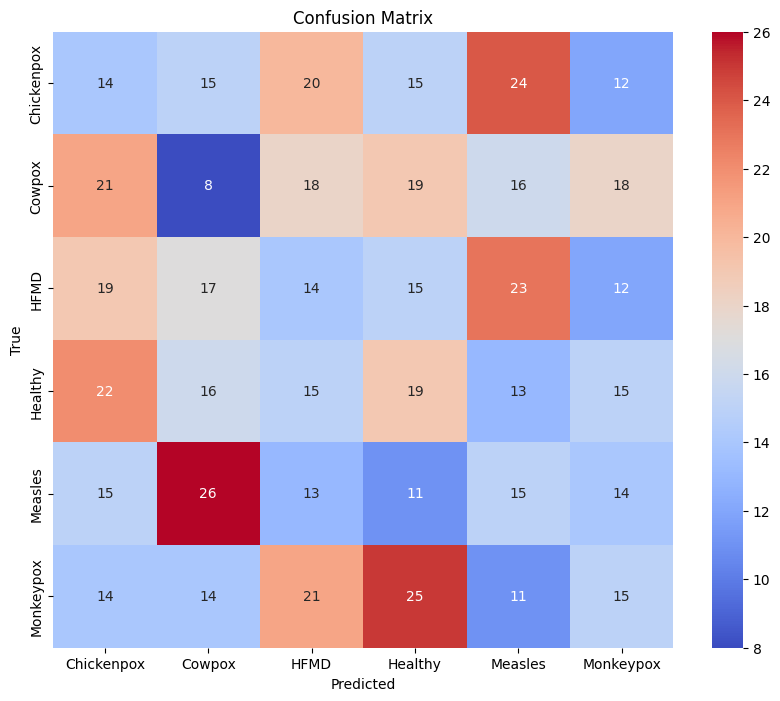

In [41]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/xception_hp_confusion_matrix.png'
plt.savefig(heatmap_file)

In [42]:
model.save(f"{CNN_MODEL_RESULTS}/xception_hp.h5")

2025-03-12 23:08:13.629745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


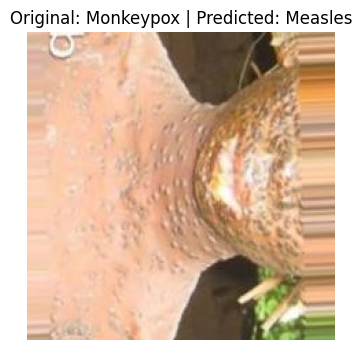

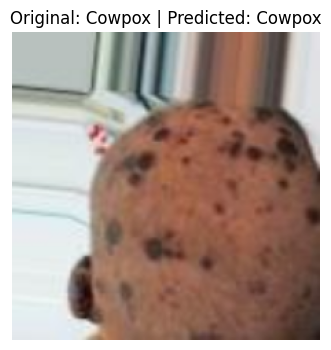

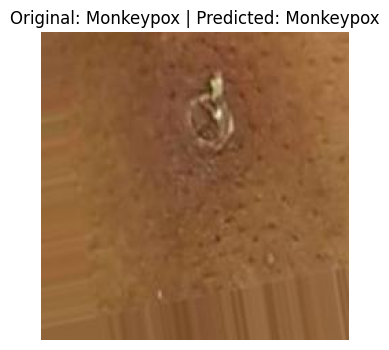

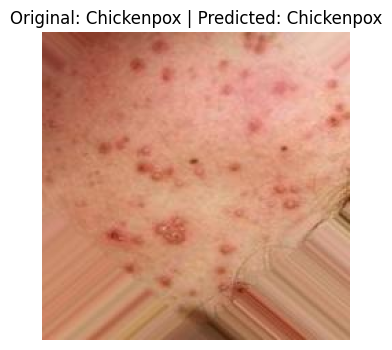

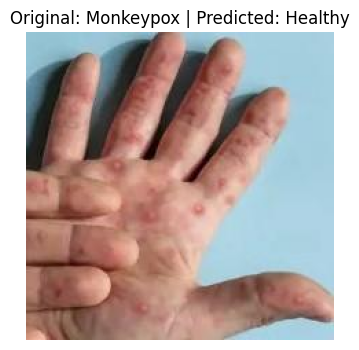

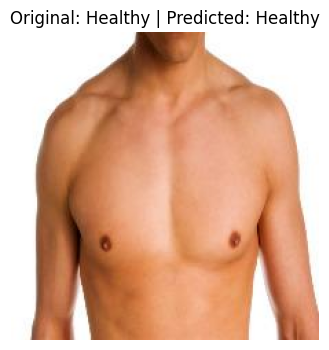

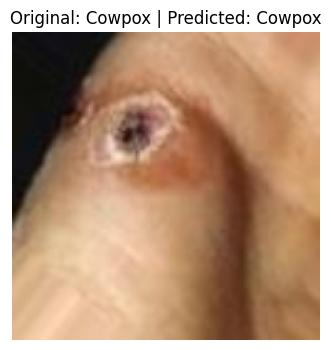

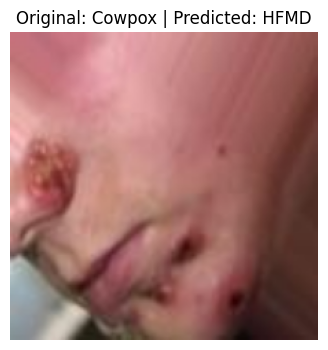

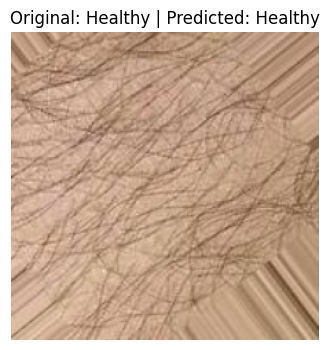

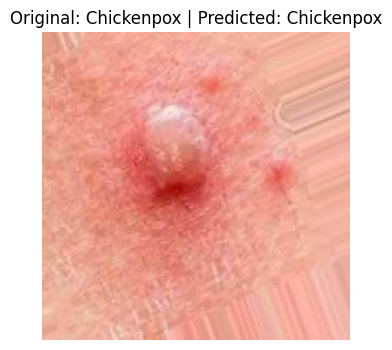

In [43]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.xception.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices.items()}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {label} | Predicted: {predicted_class}")

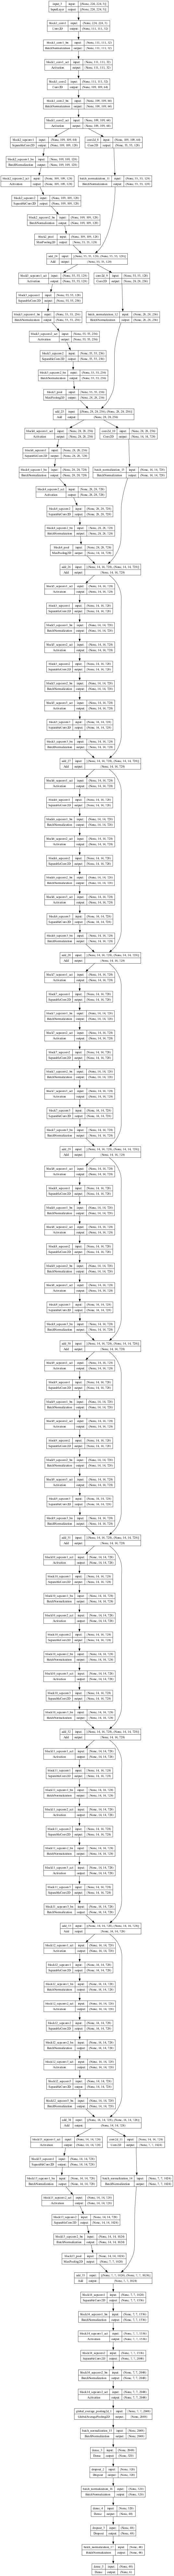

In [44]:
model = tf.keras.models.load_model(f"{CNN_MODEL_RESULTS}/xception_hp.h5")
tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/xception_hp_model_summary.png", show_shapes=True, dpi=50)